#### STEP 1 : Load and explore the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("student_scores.csv")
print(df.shape)

(1000, 8)


In [11]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


In [5]:
print(df.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [6]:
print(df.describe())

       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000


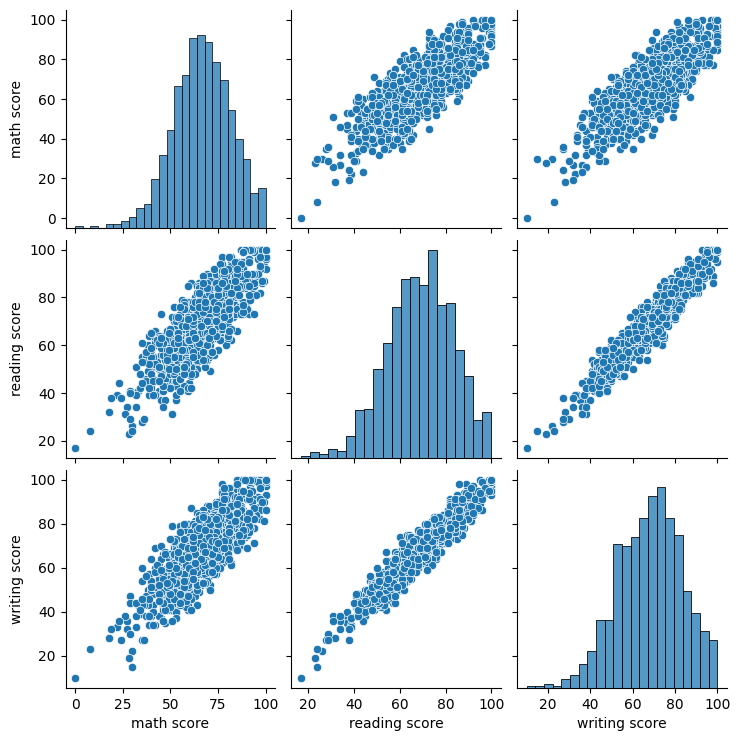

In [7]:
sns.pairplot(df)

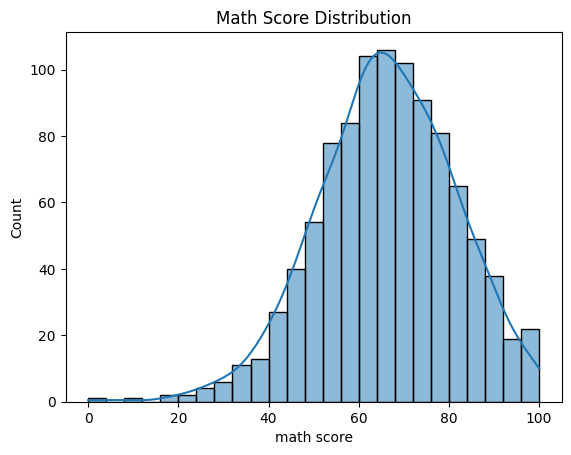

In [10]:
sns.histplot(df["math score"], kde=True)
plt.title("Math Score Distribution")
plt.show()


#### STEP 2: Feature Selection & Correlation Analysis

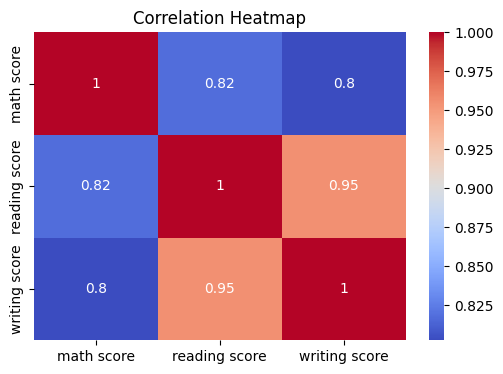

In [12]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[["math score", "reading score", "writing score"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

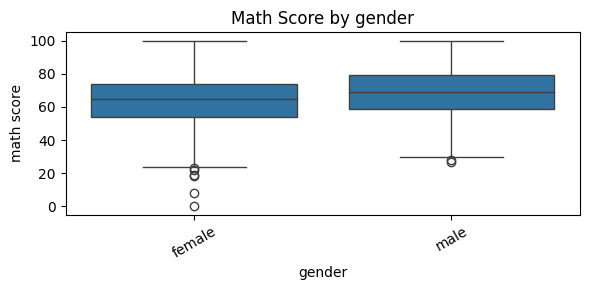

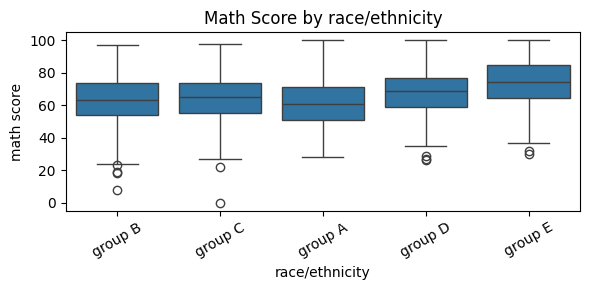

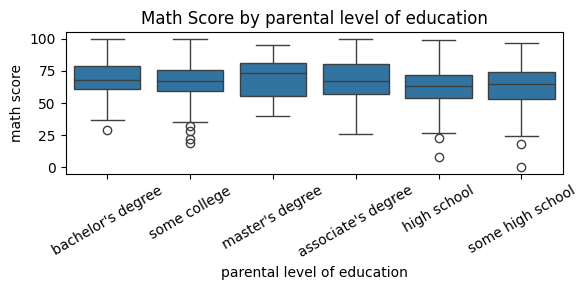

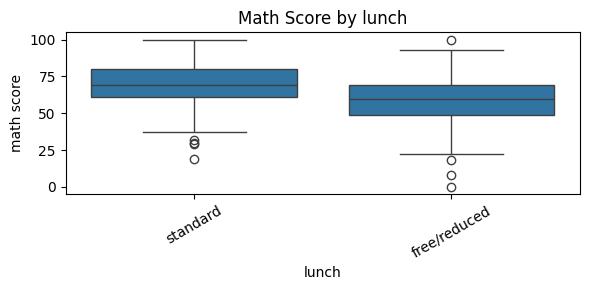

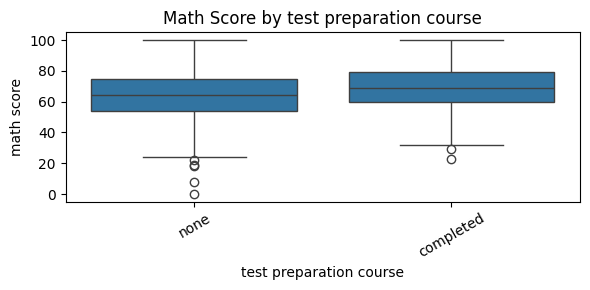

In [13]:
cat_features = ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course"]

for col in cat_features:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=col, y="math score", data=df)
    plt.title(f"Math Score by {col}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

#### STEP 3: Preprocessing (One-Hot, Scale, Split)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [15]:
X = df.drop(columns=["math score"])  # all except target
y = df["math score"]                 # target

cat_cols = X.select_dtypes(include="object").columns
num_cols = ["reading score", "writing score"]

In [16]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [17]:
# Combine with ColumnTransformer
preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, cat_cols),
    ("num", num_pipeline, num_cols)
])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### STEP 4: Modeling – Try Linear Regression & Random Forest

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

In [20]:
# Model 1: Linear Regression
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Model 2: Random Forest
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [22]:
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

In [23]:
print("--- Linear Regression ---")
print("R2 Score:", r2_score(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))

--- Linear Regression ---
R2 Score: 0.8804332983749563
MSE: 29.095169866715526


In [24]:
print("\n--- Random Forest ---")
print("R2 Score:", r2_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))


--- Random Forest ---
R2 Score: 0.8512822812106478
MSE: 36.18873174185091


#### STEP 5: Hyperparameter Tuning (RandomizedSearchCV)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Create full pipeline with preprocessing + model
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [26]:
param_dist = {
    "regressor__n_estimators": [50, 100, 200, 300],
    "regressor__max_depth": [None, 10, 20, 30, 50],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ['auto', 'sqrt', 'log2']
}


In [27]:
random_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=20,                   # Try 20 random combinations
    scoring='r2',                # Optimize for R²
    cv=5,                        # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                    # Use all processors
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Admin\Documents\GitHub\Dartvolution\dartland\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\Documents\GitHub\Dartvolution\dartland\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\Documents\GitHub\Dartvolution\dartland\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Admin\Document

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'regressor__max_depth': [None, 10, ...], 'regressor__max_features': ['auto', 'sqrt', ...], 'regressor__min_samples_leaf': [1, 2, ...], 'regressor__min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [28]:
from sklearn.metrics import r2_score, mean_squared_error

# Best parameters and CV score
print("Best Params:", random_search.best_params_)
print("Best CV R2 Score:", random_search.best_score_)

# Evaluate on test set
y_pred_best = random_search.predict(X_test)
print("Test R2 Score:", r2_score(y_test, y_pred_best))
print("Test MSE:", mean_squared_error(y_test, y_pred_best))


Best Params: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': None}
Best CV R2 Score: 0.8269037371212986
Test R2 Score: 0.8217175606273279
Test MSE: 43.38296354504302


#### STEP 6 : Exporting final trained models

In [29]:
import joblib

In [31]:
lr_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
lr_model.fit(X_train, y_train)

joblib.dump(lr_model, "linear_regression_model.pkl")
print("✅ Linear Regression model saved.")

✅ Linear Regression model saved.


In [33]:
best_rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=None,
    random_state=42
)
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_rf)
])
rf_model.fit(X_train, y_train)

joblib.dump(rf_model, "random_forest_model.pkl")
print("✅ Random Forest model saved.")

✅ Random Forest model saved.


#### STEP 7 : Loading and testing on unknown values

In [34]:
sample = pd.DataFrame([{
    "gender": "female",
    "race/ethnicity": "group B",
    "parental level of education": "bachelor's degree",
    "lunch": "standard",
    "test preparation course": "none",
    "reading score": 72,
    "writing score": 72
}])

In [36]:
lr_loaded = joblib.load("linear_regression_model.pkl")
rf_loaded = joblib.load("random_forest_model.pkl")

print("Models loaded successfully.")

Models loaded successfully.


In [37]:
pred_lr = lr_loaded.predict(sample)[0]
print(f"Linear Regression Prediction: {pred_lr:.2f}")

# Predict with Random Forest
pred_rf = rf_loaded.predict(sample)[0]
print(f"Random Forest Prediction: {pred_rf:.2f}")

Linear Regression Prediction: 64.66
Random Forest Prediction: 67.20
